# PMPET Workflow Notebook
本 Notebook 用于：
- 正确 **配置路径** 与 **变量名**，调用 `PMPET_v3.py` 的 `PenMon` 与 `PriestleyTaylor`；
- **可视化** 参考蒸散（PET/ET0）、平流/辐射分量和 VPD（地图与时间序列）；
- **快速自检**：可选的**合成数据**生成器，没数据也能跑通流程。

> 使用前请将 `PMPET_v3.py` 放在同一目录（已上传）。如需使用你自己的 NetCDF，请在“路径与变量配置”里修改。


## 1) 环境依赖
需要 `xarray`, `numpy`, `matplotlib`, `netCDF4`. （默认环境已具备）


In [4]:
import os, sys, json, math, datetime
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# 保证能 import 到 PMPET_v3.py（同目录）
sys.path.append(os.getcwd())
import PMPET_v3 as pm

print('Loaded PMPET_v3 from:', pm.__file__)

Loaded PMPET_v3 from: c:\GitHub\PET\PMPET_v3.py


## 2) 路径与变量配置
- 如果你有真实的 CMIP6/ERA 文件，请修改 `path_dict` 与 `variable_dict`。
- 若没有真实数据，可先跳过，直接运行 **第 4 节：合成数据测试**。


In [5]:
# === 路径示例（请根据你的本地情况修改）===
# 若你想使用 SH/LH 计算净辐射 (rnet_calculated=True)，则可以不提供 rnet_path
# 提醒：很多数据经常使用 latitude/longitude 作为坐标名（而非 lat/lon），需要在调用函数时指定 latname/lonname。

path_dict = {
    # 必需：
    'temp_path':  '/path/to/tas_file.nc',     # 2m air temperature
    'rh_path':    '/path/to/hurs_file.nc',    # relative humidity (%)
    'ps_path':    '/path/to/ps_file.nc',      # surface pressure (Pa)
    # 可选：用于计算 rnet = SH + LH
    'sh_path':    '/path/to/hfss_file.nc',    # sensible heat flux (W/m^2)
    'lh_path':    '/path/to/hfls_file.nc',    # latent heat flux (W/m^2)
    # 可选：若你有直接的净辐射变量（单位需留意），可设置 rnet_calculated=False，并提供 rnet_path
    # 'rnet_path':  '/path/to/rnet_file.nc',
    # 可选：风速；不存在则用常数风速
    'wind_path':  '/path/to/sfcWind_file.nc', # 10m wind speed (m/s)
    # 可选：若用露点温度推 VPD，则提供 dewpoint
    # 'tdew_path':  '/path/to/tdew_file.nc',
}

# === 变量名示例（请根据 NetCDF 文件内变量名修改）===
variable_dict = {
    'temp': 'tas',      # Air temperature
    'rnet': 'SRFRAD',   # If providing rnet file (否则不生效)
    'wind': 'sfcWind',  # Wind speed
    'rh':   'hurs',     # Relative humidity (%)
    'sh':   'hfss',     # Sensible heat flux (W/m^2)
    'lh':   'hfls',     # Latent heat flux (W/m^2)
    'ps':   'ps',       # Surface pressure (Pa)
    # 'tdew': 'tdps',   # Dew point temp (可选)
}

# 常见坐标名：'lat'/'lon' 或 'latitude'/'longitude'
latname = 'lat'       # 若你的文件用 'latitude'，请改成 'latitude'
lonname = 'lon'       # 若你的文件用 'longitude'，请改成 'longitude'

# rnet来源：True 表示用 SH+LH 估算 (单位默认 W/m^2)；False 表示直接从 rnet_path 读取
rnet_calculated = True
rnet_units = 'W/m2'   # 若 rnet 文件是逐日累积 J/m^2/day，改为 'J/m2/day'

# 风：若 wind_path 不存在，使用常数风速
wind_meas_height = 10.0  # 10m 风，函数内部会按 FAO56 转换到 2m
const_wind = 1.0         # 当 wind 文件缺失时使用的常数风速

# 植被类型：'grass' 或 'alfalfa'
veg_type = 'grass'

## 3) 运行真实计算（若你已有数据）
下面将调用：
- `pm.PenMon(...)` 计算 **Penman–Monteith PET (ET0)**、**VPD**、以及 **ET0 的平流/辐射分量**；
- `pm.PriestleyTaylor(...)` 计算 **PT-PET**（纯辐射主导）。


In [ ]:
# 如果你已经配置好 path_dict/variable_dict，取消下面注释来运行
# 注意：若路径无效会抛错。

# PET_ds, VPD_ds, PETen_ds, PETad_ds = pm.PenMon(
#     path_dict=path_dict,
#     variable_dict=variable_dict,
#     veg_type=veg_type,
#     rnet_calculated=rnet_calculated,
#     rh_from_tdew=False,         # 若需用露点推 VPD，将其改为 True 并提供 tdew_path
#     wind_meas_height=wind_meas_height,
#     const_wind=const_wind,
#     rnet_units=rnet_units,
#     latname=latname,
#     lonname=lonname
# )

# PETpt_ds = pm.PriestleyTaylor(
#     path_dict=path_dict,
#     variable_dict=variable_dict,
#     rnet_calculated=rnet_calculated,
#     wind_meas_height=wind_meas_height,
#     const_wind=const_wind,
#     alpha=1.26,
#     rnet_units=rnet_units,
#     latname=latname,
#     lonname=lonname
# )

# print(PET_ds)
# print(VPD_ds)

## 4) 合成数据测试（无真实数据也能跑）
此处生成一个 4×4 网格、24 个月的**合成 NetCDF**，变量包括：
- `tas` (°C), `hurs` (%), `ps` (Pa), `hfss`/`hfls` (W/m²), `sfcWind` (m/s)。

> 你可以用它测试函数是否可跑、可视化流程是否正确。


In [6]:
import pandas as pd

# 合成时空网格
time = pd.date_range('2001-01-01', periods=24, freq='MS')
lat = np.linspace(30, 45, 4)
lon = np.linspace(-120, -105, 4)

def make_da(data, name, units):
    da = xr.DataArray(
        data,
        coords={'time': time, 'lat': lat, 'lon': lon},
        dims=('time','lat','lon'),
        name=name
    )
    da.attrs['units'] = units
    return da

# 生成简单的空间梯度 + 时间季节性
def seasonal(base, amp, phase=0.0):
    t = np.arange(len(time))
    return base + amp*np.sin(2*np.pi*(t/12.0 + phase))

# 构造变量
tas_vals = np.zeros((len(time), len(lat), len(lon)))
hurs_vals = np.zeros_like(tas_vals)
ps_vals = np.ones_like(tas_vals) * 101325.0  # Pa
hfss_vals = np.zeros_like(tas_vals)
hfls_vals = np.zeros_like(tas_vals)
wind_vals = np.zeros_like(tas_vals)

for i in range(len(lat)):
    for j in range(len(lon)):
        tas_vals[:, i, j] = seasonal(20 + 0.1*i + 0.1*j, 10, phase=0.0)  # °C
        hurs_vals[:, i, j] = seasonal(60 - 0.5*i, 10, phase=0.25)        # %
        hfss_vals[:, i, j] = seasonal(40 + i + j, 10, phase=0.1)         # W/m2
        hfls_vals[:, i, j] = seasonal(80 + i + j, 20, phase=0.2)         # W/m2
        wind_vals[:, i, j] = 2.0 + 0.2*i + 0.1*j                         # m/s (常数风随格点变化)

ds_synth = xr.Dataset({
    'tas': make_da(tas_vals, 'tas', 'C'),
    'hurs': make_da(hurs_vals, 'hurs', '%'),
    'ps': make_da(ps_vals, 'ps', 'Pa'),
    'hfss': make_da(hfss_vals, 'hfss', 'W m-2'),
    'hfls': make_da(hfls_vals, 'hfls', 'W m-2'),
    'sfcWind': make_da(wind_vals, 'sfcWind', 'm s-1')
})

# 写到临时 NetCDF 文件
tmp_dir = '/mnt/data/synth_demo'
os.makedirs(tmp_dir, exist_ok=True)
for v in ds_synth.data_vars:
    out_path = os.path.join(tmp_dir, f'{v}.nc')
    ds_synth[[v]].to_netcdf(out_path)

# 使用合成数据路径
path_dict_demo = {
    'temp_path': os.path.join(tmp_dir, 'tas.nc'),
    'rh_path':   os.path.join(tmp_dir, 'hurs.nc'),
    'ps_path':   os.path.join(tmp_dir, 'ps.nc'),
    'sh_path':   os.path.join(tmp_dir, 'hfss.nc'),
    'lh_path':   os.path.join(tmp_dir, 'hfls.nc'),
    'wind_path': os.path.join(tmp_dir, 'sfcWind.nc'),
    # 不提供 rnet_path，使用 SH+LH 计算
}

variable_dict_demo = {
    'temp': 'tas',
    'rnet': 'SRFRAD',    # 不使用（我们用 SH+LH）
    'wind': 'sfcWind',
    'rh':   'hurs',
    'sh':   'hfss',
    'lh':   'hfls',
    'ps':   'ps',
}

PET_demo, VPD_demo, PETen_demo, PETad_demo = pm.PenMon(
    path_dict=path_dict_demo,
    variable_dict=variable_dict_demo,
    veg_type='grass',
    rnet_calculated=True,
    rh_from_tdew=False,
    wind_meas_height=10.0,
    const_wind=1.0,
    rnet_units='W/m2',
    latname='lat',
    lonname='lon'
)

PETpt_demo = pm.PriestleyTaylor(
    path_dict=path_dict_demo,
    variable_dict=variable_dict_demo,
    rnet_calculated=True,
    wind_meas_height=10.0,
    const_wind=1.0,
    alpha=1.26,
    rnet_units='W/m2',
    latname='lat',
    lonname='lon'
)

print(PET_demo)
print(VPD_demo)

Scaling wind from height of 10.0 m to 2m
<xarray.Dataset> Size: 3kB
Dimensions:  (time: 24, lat: 4, lon: 4)
Coordinates:
  * time     (time) datetime64[ns] 192B 2001-01-01 2001-02-01 ... 2002-12-01
  * lat      (lat) float64 32B 30.0 35.0 40.0 45.0
  * lon      (lon) float64 32B -120.0 -115.0 -110.0 -105.0
Data variables:
    PET      (time, lat, lon) float64 3kB 3.889 3.956 4.023 ... 3.582 3.64 3.699
<xarray.Dataset> Size: 3kB
Dimensions:  (time: 24, lat: 4, lon: 4)
Coordinates:
  * time     (time) datetime64[ns] 192B 2001-01-01 2001-02-01 ... 2002-12-01
  * lat      (lat) float64 32B 30.0 35.0 40.0 45.0
  * lon      (lon) float64 32B -120.0 -115.0 -110.0 -105.0
Data variables:
    VPD      (time, lat, lon) float64 3kB 0.7015 0.7058 0.7102 ... 0.5783 0.582


## 5) 可视化：地图与时间序列
- 地图：选择某一时刻，绘制 PET、PET(adv)、PET(rad)、VPD；
- 时间序列：对单点或区域平均做 TS。


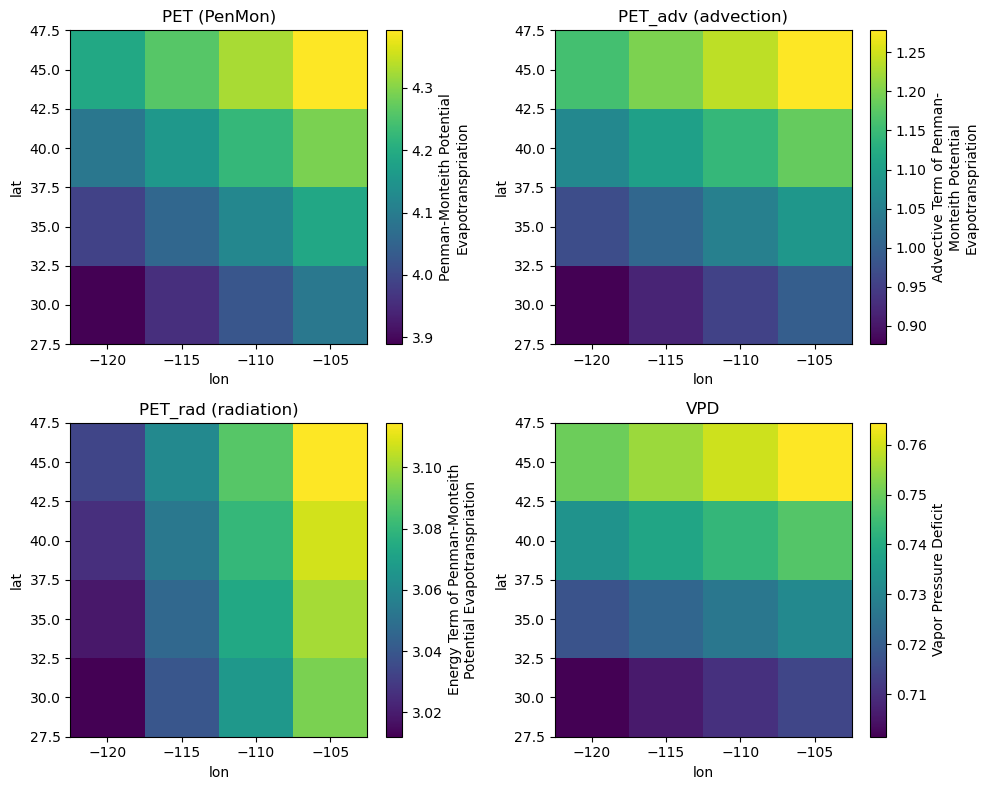

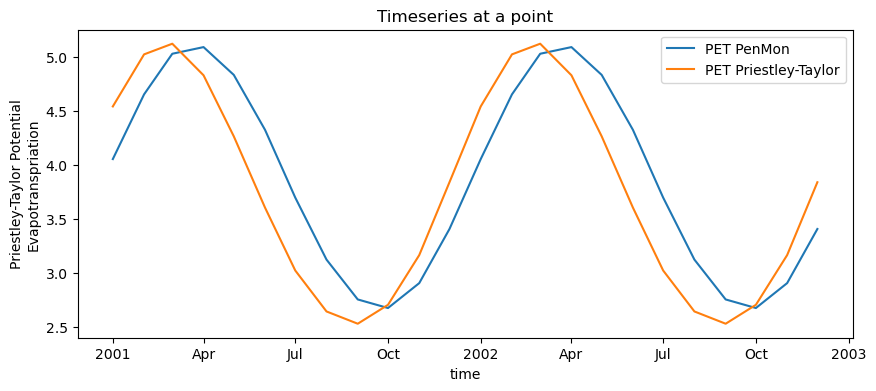

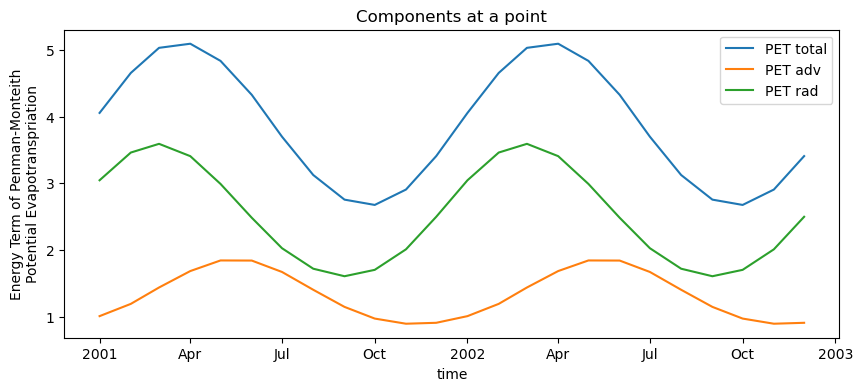

In [7]:
# 选择时间索引
tidx = 0  # 第一个月

# 地图 (使用合成数据)
fig, axes = plt.subplots(2, 2, figsize=(10,8))
PET_demo['PET'].isel(time=tidx).plot(ax=axes[0,0])
axes[0,0].set_title('PET (PenMon)')

PETad_demo['PET'].isel(time=tidx).plot(ax=axes[0,1])
axes[0,1].set_title('PET_adv (advection)')

PETen_demo['PET'].isel(time=tidx).plot(ax=axes[1,0])
axes[1,0].set_title('PET_rad (radiation)')

VPD_demo['VPD'].isel(time=tidx).plot(ax=axes[1,1])
axes[1,1].set_title('VPD')
plt.tight_layout()
plt.show()

# 时间序列（取单点）
ilat, ilon = 1, 1
fig, ax = plt.subplots(figsize=(10,4))
PET_demo['PET'].isel(lat=ilat, lon=ilon).plot(label='PET PenMon', ax=ax)
PETpt_demo['PET'].isel(lat=ilat, lon=ilon).plot(label='PET Priestley-Taylor', ax=ax)
ax.legend(); ax.set_title('Timeseries at a point')
plt.show()

# 组件比较（单点）
fig, ax = plt.subplots(figsize=(10,4))
PET_demo['PET'].isel(lat=ilat, lon=ilon).plot(label='PET total', ax=ax)
PETad_demo['PET'].isel(lat=ilat, lon=ilon).plot(label='PET adv', ax=ax)
PETen_demo['PET'].isel(lat=ilat, lon=ilon).plot(label='PET rad', ax=ax)
ax.legend(); ax.set_title('Components at a point')
plt.show()

## 6) 保存输出（可选）
可以将计算结果写成 NetCDF。


In [ ]:
out_dir = r'C:\GitHub\PET\outputs'
os.makedirs(out_dir, exist_ok=True)

# 合成示例输出
PET_demo.to_netcdf(os.path.join(out_dir, 'PET_penmon_demo.nc'))
VPD_demo.to_netcdf(os.path.join(out_dir, 'VPD_demo.nc'))
PETen_demo.to_netcdf(os.path.join(out_dir, 'PET_rad_demo.nc'))
PETad_demo.to_netcdf(os.path.join(out_dir, 'PET_adv_demo.nc'))
PETpt_demo.to_netcdf(os.path.join(out_dir, 'PET_pt_demo.nc'))

print('Saved to', out_dir)

Saved to C:\GitHub\PET
